In [1]:
#ASTR 3070 Data Reduction
# packages used... 

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm


import astropy.units as u
from astropy.visualization import simple_norm
from astropy.wcs import WCS
from astropy.coordinates import angular_separation, Angle, SkyCoord
from astropy.wcs.utils import proj_plane_pixel_scales
from astropy.stats import sigma_clipped_stats
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.nddata import Cutout2D

# for directory
import os

# fo rallighining
import astroalign as align

# twirl
from twirl import find_peaks
from twirl import gaia_radecs
from twirl.geometry import sparsify
from twirl import compute_wcs

from photutils.aperture import SkyCircularAperture
from photutils.detection import DAOStarFinder
from pylab import figure, cm

import pandas as pd

In [2]:
#Unpack the files

DIRECTORY="m2/"

flats1B_directory=DIRECTORY+"Night 1/flats/B"
flats1R_directory=DIRECTORY+"Night 1/flats/R"
flats2B_directory=DIRECTORY+"Night 2/flats/B"
flats2R_directory=DIRECTORY+"Night 2/flats/R"
darks_directory=DIRECTORY+"darks/120/"   #Darks images
bias_directory=DIRECTORY+"bias/2x2/"    #Bias images
light1B_directory=DIRECTORY+"Night 1/B"
light1R_directory=DIRECTORY+"Night 1/R"
light2B_directory=DIRECTORY+"Night 2/B"
light2R_directory=DIRECTORY+"Night 2/R"

In [3]:
#Make a function to get the filenames so then I can open the fits files.

def get_filename(directory):
    '''
    This gives all the filenames that are in a folder and returns them in list format
    '''
    filename_list=[]
    for filename in os.scandir(directory):
        if os.path.isfile(filename):
            filename_list.append(filename)
    return(filename_list)


In [4]:
#Get all the filenames
flats1B_files=get_filename(flats1B_directory)
flats1R_files=get_filename(flats1R_directory)
flats2B_files=get_filename(flats2B_directory)
flats2R_files=get_filename(flats2R_directory)
darks_files=get_filename(darks_directory)
bias_files=get_filename(bias_directory)
light1B_files=get_filename(light1B_directory)
light1R_files=get_filename(light1R_directory)
light2B_files=get_filename(light2B_directory)
light2R_files=get_filename(light2R_directory)

In [5]:
def make_master(file_list):
    '''
    This takes a list of filenames
    Loads the data, averages all the images together
    Returns a master image
    '''
    imgs1=fits.open(file_list[0])
    data=imgs1[0].data

    height=len(data[:,0])
    width=len(data[0,:])
    
    master_img=np.zeros((height, width))
    count=0
    for file in file_list:
        count+=1
        imgs=fits.open(file)
        img_data=imgs[0].data
        master_img=master_img+img_data

    master_img=master_img/count

    return master_img

In [6]:
#Get the master flat, bias, and dark images
flat1B_img=make_master(flats1B_files)
flat1R_img=make_master(flats1R_files)
flat2B_img=make_master(flats2B_files)
flat2R_img=make_master(flats2R_files)
bias_img=make_master(bias_files)
darks_img=make_master(darks_files)

In [7]:
#Make the master flat and bias corrected images
flat1B_bias=flat1B_img-bias_img #Subtract the bias from the flats
flat1R_bias=flat1R_img-bias_img
flat2B_bias=flat2B_img-bias_img
flat2R_bias=flat2R_img-bias_img

norm_flat1B_bias=flat1B_bias/np.max(flat1B_bias) #Normalize by dividing by the maximum value of the array
norm_flat1R_bias=flat1R_bias/np.max(flat1R_bias)

norm_flat2B_bias=flat2B_bias/np.max(flat2B_bias)
norm_flat2R_bias=flat2R_bias/np.max(flat2R_bias)

In [8]:
light1B_ref_img=fits.open(light1B_files[0]) #Get the first header to make that the WCS
light1B_ref_header=light1B_ref_img[0].header
ref_RA=light1B_ref_header["RA"]
ref_DEC=light1B_ref_header["DEC"]
light1B_ref_data=light1B_ref_img[0].data


In [9]:
def make_header_data_lists(light, dark, norm_flats_bias):
    '''
    light = list of light file names
    dark = master dark image
    norm_flats_bias = normalized bias subtracted flat images

    returns - list of image HDUs
    '''
    corr_HDU_list=[]
    for file in light:
        light_imgs=fits.open(file)
        light_data=light_imgs[0].data
        #light_header=light_imgs[0].header
        light_corr=(light_data-dark)/norm_flats_bias
        corr_HDU_list.append(light_corr)
    return corr_HDU_list

In [10]:
HDU1B_list=make_header_data_lists(light1B_files, darks_img, norm_flat1B_bias)
#HDU2_list=make_header_data_lists(light2_files, darks_img, norm_flat2_bias)

In [11]:
#Do astroalign and then use astroquery to get RA and DEC


def align_image(list_of_images, reference_image):
    height=len(reference_image[:,0])
    width=len(reference_image[0,:])
    Master_image=np.zeros((height, width))
    count=0

    for image in list_of_images:
        count+=1
        aligned_image, footprint=align.register(image, reference_image)
        Master_image=Master_image+aligned_image

    Master_image=Master_image/count

    return Master_image

light1B_master=align_image(HDU1B_list, light1B_ref_data)
#light2_master=align_image(HDU2_list, light1_ref_data)


In [12]:
hdul1B=fits.PrimaryHDU(light1B_master, light1B_ref_header)
#hdul2=fits.PrimaryHDU(light2_master, light1_ref_header)

outfile1=DIRECTORY+"Light_Nov2_MASTER_mean_wrong_RA_DEC.fits"
#outfile2=DIRECTORY+"Light_Nov5_MASTER_mean_wrong_RA_DEC.fits"

hdul1B.writeto(outfile1, overwrite=True)
#hdul2.writeto(outfile2, overwrite=True)

In [13]:
image1 = fits.open(outfile1)

In [14]:
image1[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 4784                                                  
NAXIS2  =                 3194                                                  
IMAGETYP= 'LIGHT'              / Type of exposure                               
EXPOSURE=                120.0 / [s] Exposure duration                          
EXPTIME =                120.0 / [s] Exposure duration                          
DATE-LOC= '2024-11-02T21:36:08.496' / Time of observation (local)               
DATE-OBS= '2024-11-03T03:36:08.496' / Time of observation (UTC)                 
DATE-AVG= '2024-11-03T03:37:12.178' / Averaged midpoint time (UTC)              
XBINNING=                    2 / X axis binning factor                          
YBINNING=                   

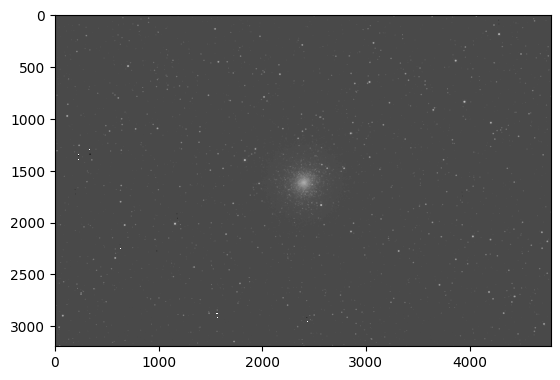

In [15]:

plt.imshow(image1[0].data, cmap=cm.gray, norm=LogNorm(vmin=1, vmax=100000))

In [16]:
image1.writeto("M2_B_Nov02.fits", overwrite = True)

In [17]:
data = image1[0].data[1000:1400, 2300:2700]

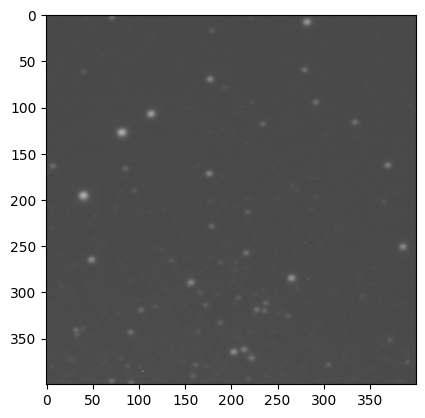

In [18]:
plt.imshow(data, cmap=cm.gray, norm=LogNorm(vmin=1, vmax=100000))
plt.savefig('subset.png')

In [19]:
mean, median, std = sigma_clipped_stats(data, sigma=3.0)

In [20]:
print(np.array((mean, median, std)))

[29.01562811 28.86854513  1.39053516]


In [21]:
from photutils.detection import DAOStarFinder
daofind = DAOStarFinder(fwhm=5.0, threshold=3.*std)
sources = daofind(data - median)
for col in sources.colnames:  

    if col not in ('id', 'npix'):

        sources[col].info.format = '%.2f'  # for consistent table output

In [22]:
sources.pprint(max_width=76)

 id xcentroid ycentroid sharpness ...  peak    flux    mag   daofind_mag
--- --------- --------- --------- ... ------ -------- ------ -----------
  1     70.62      3.01      0.51 ... 114.12  2006.77  -8.26       -3.97
  2     42.66      3.57      0.67 ...   5.17    48.09  -4.21       -0.64
  3    220.50      3.57      0.53 ...  12.09   201.88  -5.76       -1.52
  4    141.37      5.47      0.89 ...   2.28   -44.38    nan       -0.07
  5    281.62      8.00      0.51 ... 861.86 15219.91 -10.46       -6.15
  6    179.07     17.38      0.50 ...  38.99   663.08  -7.05       -2.83
  7    114.81     22.10      0.31 ...   2.57    27.34  -3.59       -0.58
  8    358.19     24.69      0.68 ...   3.53    20.32  -3.27       -0.27
  9    113.40     31.34      0.41 ...   1.48    -4.29    nan       -0.13
 10    102.54     40.27      0.47 ...   2.41    20.81  -3.30       -0.19
...       ...       ...       ... ...    ...      ...    ...         ...
271    120.36    394.94      0.57 ...   7.83   275.

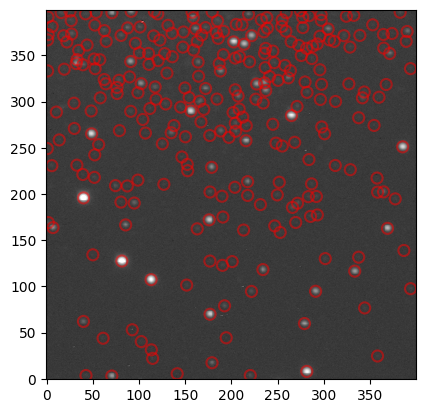

In [23]:
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils.aperture import CircularAperture
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
apertures = CircularAperture(positions, r=6.0)
plt.imshow(data, cmap=cm.gray, origin='lower', norm=LogNorm(vmin=10, vmax=1000),interpolation='nearest')
apertures.plot(color='red', lw=1.5, alpha=0.5)

In [24]:
#result = a.solve_from_image('M2_B_Nov02.fits', ra_key='RA', dec_key='DEC')
#result = a.solve_from_image('M2_B_Nov02.fits', center_ra=323.37641682792, center_dec=-0.779124132264951, radius=0.005, scale_units='arcsecperpix', scale_lower=0.95, scale_upper=1.0, use_sextractor=True)

In [25]:
#result = a.solve_from_image(image_file_path='subset.png', format='png', scale_units='arcsecperpix', scale_lower=0.95, scale_upper=1.0)

In [26]:
#from astropy.wcs.utils import proj_plane_pixel_scales

In [27]:
xy = find_peaks(image1[0].data)[0:20]

In [28]:
xy

array([[2395.87199168, 1621.18270829],
       [3940.65303138,  843.12371442],
       [1154.81174796, 2016.49178111],
       [1826.49428265, 1404.58656187],
       [2561.7874068 , 1837.56959206],
       [4274.1950503 ,  193.52487158],
       [3856.02063916,  447.74500053],
       [4021.61828161, 2139.32815961],
       [3026.76506203,  653.6811703 ],
       [ 702.91213892,  500.3388415 ],
       [4194.50916875, 1044.64793016],
       [2846.33484201, 1147.67426063],
       [  74.18805328, 2901.05847373],
       [ 117.36554045,  980.19835906],
       [ 669.79483156, 2029.67140851],
       [ 579.38958015, 2346.19057804],
       [2848.44164497, 2091.89125145],
       [3307.17791051, 2279.32201563],
       [4423.53704879, 2716.6431023 ],
       [ 986.00715198, 1099.94476703]])

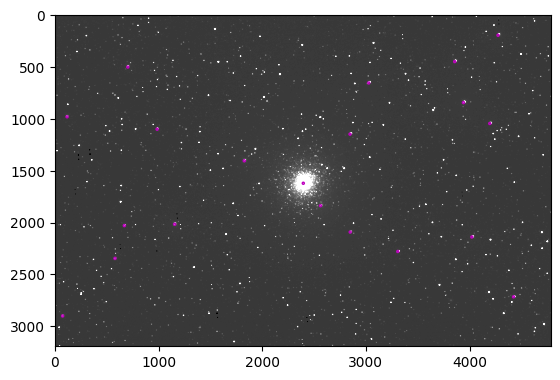

In [29]:
plt.imshow(image1[0].data, vmin=0.1*np.median(image1[0].data), vmax=5 * np.median(image1[0].data), cmap="Greys_r")
_ = CircularAperture(xy, r=10.0).plot(color="m")

In [ ]:
true_wcs = WCS(image1[0].header)
fov = (image1[0].data.shape * proj_plane_pixel_scales(true_wcs))[0]

Set MJD-AVG to 60617.150835 from DATE-AVG'. [astropy.wcs.wcs]


In [31]:
mean, median, std = sigma_clipped_stats(image1[0].data, sigma=3.0)

In [32]:
#center = true_wcs.pixel_to_world(*np.array(data.shape) / 2)

In [33]:
image1[0].data.shape

(3194, 4784)

In [34]:
image1[0].header['RA']

323.374739132319

In [35]:
image1[0].header['DEC']

-0.78662096883639

In [36]:
print(3194/2*0.98/60/60)
print(4784/2*0.98/60/60)

0.4347388888888889
0.6511555555555556


In [37]:


all_radecs = gaia_radecs((323.37641682792,-0.779124132264951), 1.2 * 0.65)

# we only keep stars 0.01 degree apart from each other
all_radecs = sparsify(all_radecs, 0.01)

In [38]:
all_radecs

array([[323.20615347,  -0.88319508],
       [323.40832683,  -0.76370433],
       [323.53675925,  -1.08929894],
       ...,
       [323.72392683,  -0.90633067],
       [323.58683091,  -0.57694153],
       [323.48956434,  -0.50193977]])

In [39]:

# we only keep the 12 brightest stars from gaia
wcs = compute_wcs(xy, all_radecs[0:30], tolerance=10)

In [40]:
wcs

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 323.409699260536  -0.8655837745227385  
CRPIX : 2567.29781360823  1468.3790779102128  
CD1_1 CD1_2  : 0.0002751449089631077  -3.5265013762961006e-07  
CD2_1 CD2_2  : 4.33976836262557e-07  0.0002751753781807376  
NAXIS : 3308  2280

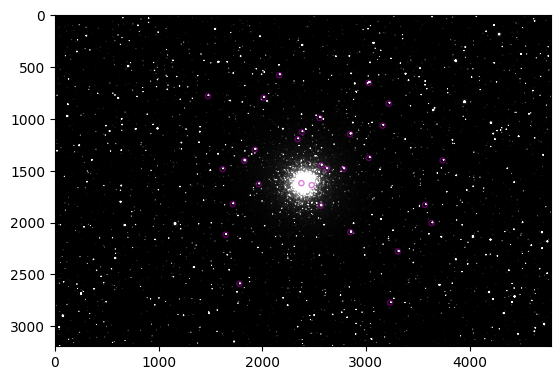

In [41]:
# plotting to check the WCS
radecs_xy = np.array(wcs.world_to_pixel_values(all_radecs))
plt.imshow(image1[0].data, vmin=np.median(image1[0].data), vmax=3 * np.median(image1[0].data), cmap="Greys_r")
_ = CircularAperture(radecs_xy[0:30], 25).plot(color="m", alpha=0.5)

In [42]:
image1[0].header.update(wcs.to_header())
image1[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 4784                                                  
NAXIS2  =                 3194                                                  
IMAGETYP= 'LIGHT'              / Type of exposure                               
EXPOSURE=                120.0 / [s] Exposure duration                          
EXPTIME =                120.0 / [s] Exposure duration                          
DATE-LOC= '2024-11-02T21:36:08.496' / Time of observation (local)               
DATE-OBS= '2024-11-03T03:36:08.496' / Time of observation (UTC)                 
DATE-AVG= '2024-11-03T03:37:12.178' / Averaged midpoint time (UTC)              
XBINNING=                    2 / X axis binning factor                          
YBINNING=                   

In [43]:
image1[0].data = image1[0].data/(16*120.0)
# image1[0].writeto('../Nov02Bimagewcs.fits', overwrite=True)

In [44]:
image1[0].data

array([[0.0144558 , 0.01383648, 0.01449565, ..., 0.01362253, 0.01394128,
        0.01407206],
       [0.01444045, 0.01464738, 0.01435635, ..., 0.01466528, 0.01410718,
        0.01476252],
       [0.01523953, 0.01458837, 0.01437854, ..., 0.01399203, 0.01391617,
        0.01476917],
       ...,
       [0.014365  , 0.01418299, 0.01375786, ..., 0.01438487, 0.01383741,
        0.01452004],
       [0.01432489, 0.01376466, 0.01420701, ..., 0.01505459, 0.01415836,
        0.01370015],
       [0.01408844, 0.01415695, 0.01384042, ..., 0.01404773, 0.01365466,
        0.01379521]])

In [45]:
coords = pd.read_csv("NGC7089.pos", sep='[ ]{2,}', engine='python')
mags = pd.read_csv("NGC7089.pho", sep='[ ]{1,}', engine='python')

In [46]:
coords

,323.36209232807,-00.84555554920,21 33 26.90 -00 50 44.0,0.00,0.00.1,8138.0,7118.0,Reference
0,323.394972,- 0.86221652031,21 33 34.79 -00 51 44.0,118.35,-59.98,8729.8,6818.1,M2-S1
1,323.388666,- 0.82577629195,21 33 33.28 -00 49 32.8,95.66,71.20,8616.3,7474.0,M2-S2
2,323.392878,- 0.84881764942,21 33 34.29 -00 50 55.7,110.81,-11.74,8692.1,7059.3,M2-S4
3,323.390901,- 0.83697738700,21 33 33.82 -00 50 13.1,103.70,30.88,8656.5,7272.4,M2-S6
4,323.395248,- 0.86062790659,21 33 34.86 -00 51 38.3,119.35,-54.26,8734.7,6846.7,M2-S8
...,...,...,...,...,...,...,...,...
1440,323.572509,- 0.62638672935,21 34 17.40 -00 37 35.0,757.46,788.99,11925.3,11062.9,M2-S1662
1441,323.573094,- 0.88314695358,21 34 17.54 -00 52 59.3,759.51,-135.35,11935.6,6441.3,M2-S1663
1442,323.574565,- 0.60667417155,21 34 17.90 -00 36 24.0,764.86,859.95,11962.3,11417.8,M2-S1664
1443,323.577047,- 0.91212888824,21 34 18.49 -00 54 43.7,773.74,-239.69,12006.7,5919.6,M2-S1665


In [47]:
coords.rename(columns={'323.36209232807' : 'RA', '-00.84555554920' : 'DEC'}, inplace=True)
coords.DEC = coords.DEC.str.replace(" ", "")
coords.DEC = coords.DEC.astype(float)

In [48]:
coords

,RA,DEC,21 33 26.90 -00 50 44.0,0.00,0.00.1,8138.0,7118.0,Reference
0,323.394972,-0.862217,21 33 34.79 -00 51 44.0,118.35,-59.98,8729.8,6818.1,M2-S1
1,323.388666,-0.825776,21 33 33.28 -00 49 32.8,95.66,71.20,8616.3,7474.0,M2-S2
2,323.392878,-0.848818,21 33 34.29 -00 50 55.7,110.81,-11.74,8692.1,7059.3,M2-S4
3,323.390901,-0.836977,21 33 33.82 -00 50 13.1,103.70,30.88,8656.5,7272.4,M2-S6
4,323.395248,-0.860628,21 33 34.86 -00 51 38.3,119.35,-54.26,8734.7,6846.7,M2-S8
...,...,...,...,...,...,...,...,...
1440,323.572509,-0.626387,21 34 17.40 -00 37 35.0,757.46,788.99,11925.3,11062.9,M2-S1662
1441,323.573094,-0.883147,21 34 17.54 -00 52 59.3,759.51,-135.35,11935.6,6441.3,M2-S1663
1442,323.574565,-0.606674,21 34 17.90 -00 36 24.0,764.86,859.95,11962.3,11417.8,M2-S1664
1443,323.577047,-0.912129,21 34 18.49 -00 54 43.7,773.74,-239.69,12006.7,5919.6,M2-S1665


In [49]:
mags

,Reference,U,sigma,N,n,B,sigma.1,N.1,n.1,V,...,n.2,R,sigma.3,N.3,n.3,I,sigma.4,N.4,n.4,vary?
0,M2-S1,18.893,0.0053,24,34,19.029,0.0042,49,64,18.412,...,106,18.031,0.0059,22,30,17.617,0.0037,94,110,-0.117
1,M2-S2,16.843,0.0054,25,39,16.647,0.0037,53,70,15.794,...,109,15.287,0.0056,32,45,14.793,0.0036,69,89,0.021
2,M2-S4,18.754,0.0089,24,37,18.819,0.0057,53,69,18.157,...,111,17.762,0.0094,22,30,17.327,0.0050,96,115,0.033
3,M2-S6,17.380,0.0037,25,39,17.355,0.0030,54,72,16.604,...,103,16.143,0.0036,29,41,15.683,0.0024,75,96,-0.096
4,M2-S8,16.491,0.0067,25,37,16.549,0.0037,56,72,16.541,...,126,16.534,0.0090,26,37,16.525,0.0025,97,113,0.021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1440,M2-S1662,99.999,9.9999,0,0,99.999,9.9999,0,0,17.878,...,14,99.999,9.9999,0,0,17.017,0.0076,12,13,-0.079
1441,M2-S1663,99.999,9.9999,0,0,19.466,0.0109,9,12,18.872,...,20,99.999,9.9999,0,0,18.084,0.0125,13,16,-0.036
1442,M2-S1664,99.999,9.9999,0,0,16.918,0.0068,7,8,16.279,...,8,99.999,9.9999,0,0,15.454,0.0091,6,7,-0.069
1443,M2-S1665,16.383,0.0146,5,7,16.335,0.0111,8,14,15.676,...,15,99.999,9.9999,0,0,14.848,0.0101,9,14,0.027


In [50]:
stetson = pd.merge(coords[["Reference", 'RA', 'DEC']], mags, how='inner', on=['Reference'])

stetson

In [51]:
stetson

,Reference,RA,DEC,U,sigma,N,n,B,sigma.1,N.1,...,n.2,R,sigma.3,N.3,n.3,I,sigma.4,N.4,n.4,vary?
0,M2-S1,323.394972,-0.862217,18.893,0.0053,24,34,19.029,0.0042,49,...,106,18.031,0.0059,22,30,17.617,0.0037,94,110,-0.117
1,M2-S2,323.388666,-0.825776,16.843,0.0054,25,39,16.647,0.0037,53,...,109,15.287,0.0056,32,45,14.793,0.0036,69,89,0.021
2,M2-S4,323.392878,-0.848818,18.754,0.0089,24,37,18.819,0.0057,53,...,111,17.762,0.0094,22,30,17.327,0.0050,96,115,0.033
3,M2-S6,323.390901,-0.836977,17.380,0.0037,25,39,17.355,0.0030,54,...,103,16.143,0.0036,29,41,15.683,0.0024,75,96,-0.096
4,M2-S8,323.395248,-0.860628,16.491,0.0067,25,37,16.549,0.0037,56,...,126,16.534,0.0090,26,37,16.525,0.0025,97,113,0.021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1440,M2-S1662,323.572509,-0.626387,99.999,9.9999,0,0,99.999,9.9999,0,...,14,99.999,9.9999,0,0,17.017,0.0076,12,13,-0.079
1441,M2-S1663,323.573094,-0.883147,99.999,9.9999,0,0,19.466,0.0109,9,...,20,99.999,9.9999,0,0,18.084,0.0125,13,16,-0.036
1442,M2-S1664,323.574565,-0.606674,99.999,9.9999,0,0,16.918,0.0068,7,...,8,99.999,9.9999,0,0,15.454,0.0091,6,7,-0.069
1443,M2-S1665,323.577047,-0.912129,16.383,0.0146,5,7,16.335,0.0111,8,...,15,99.999,9.9999,0,0,14.848,0.0101,9,14,0.027


In [52]:
stetson = stetson[(stetson.B < 19) & (stetson.R < 19)]

In [53]:
stetson

,Reference,RA,DEC,U,sigma,N,n,B,sigma.1,N.1,...,n.2,R,sigma.3,N.3,n.3,I,sigma.4,N.4,n.4,vary?
1,M2-S2,323.388666,-0.825776,16.843,0.0054,25,39,16.647,0.0037,53,...,109,15.287,0.0056,32,45,14.793,0.0036,69,89,0.021
2,M2-S4,323.392878,-0.848818,18.754,0.0089,24,37,18.819,0.0057,53,...,111,17.762,0.0094,22,30,17.327,0.0050,96,115,0.033
3,M2-S6,323.390901,-0.836977,17.380,0.0037,25,39,17.355,0.0030,54,...,103,16.143,0.0036,29,41,15.683,0.0024,75,96,-0.096
4,M2-S8,323.395248,-0.860628,16.491,0.0067,25,37,16.549,0.0037,56,...,126,16.534,0.0090,26,37,16.525,0.0025,97,113,0.021
5,M2-S9,323.391814,-0.841135,16.647,0.0033,25,40,16.372,0.0027,54,...,110,15.000,0.0038,32,45,14.485,0.0021,69,90,-0.117
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1401,M2-S1616,323.514497,-0.973412,17.510,0.0039,16,23,17.291,0.0045,32,...,30,16.083,0.0098,12,12,15.711,0.0030,20,31,0.012
1410,M2-S1627,323.534195,-0.979178,15.529,0.0111,11,13,15.099,0.0047,25,...,20,13.651,0.0091,12,12,13.209,0.0038,12,23,0.019
1415,M2-S1634,323.539763,-0.708714,18.264,0.0059,14,15,18.336,0.0075,20,...,24,17.150,0.0105,8,8,16.731,0.0040,16,25,-0.041
1426,M2-S1647,323.557856,-0.985903,99.999,9.9999,0,0,18.377,0.0086,20,...,14,17.366,0.0154,12,12,17.019,0.0049,7,16,-0.038


In [54]:
# plotting to check the Stetson Photometric Standard Star positions
stetson_pos = np.array(wcs.world_to_pixel_values(stetson[["RA", "DEC"]]))

#stetson_pos = SkyCoord(ra=stetson.RA, dec=stetson.DEC, unit='deg')
#aper = SkyCircularAperture(stetson_pos, 0.5*u.arcsec)

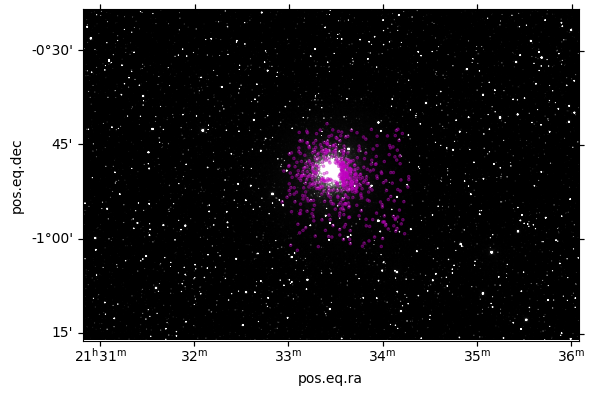

In [55]:
ax = plt.subplot(projection=wcs)
ax.imshow(image1[0].data, vmin=np.median(image1[0].data), vmax=3 * np.median(image1[0].data), cmap="Greys_r")
_ = CircularAperture(stetson_pos, 10).plot(color="m", alpha=0.5)

In [56]:
position = (2200, 1000)
size = (1000, 1000)
cutout = Cutout2D(image1[0].data, position, size, wcs=wcs)
analysis = fits.PrimaryHDU()

In [57]:
analysis.data = cutout.data
analysis.header.update(cutout.wcs.to_header())

In [ ]:
xy_cutout = find_peaks(analysis.data)[0:20]
wcs_cutout = compute_wcs(xy_cutout, all_radecs[0:30], tolerance=10)
stetson_pos = np.array(wcs_cutout.world_to_pixel_values(stetson[["RA", "DEC"]]))


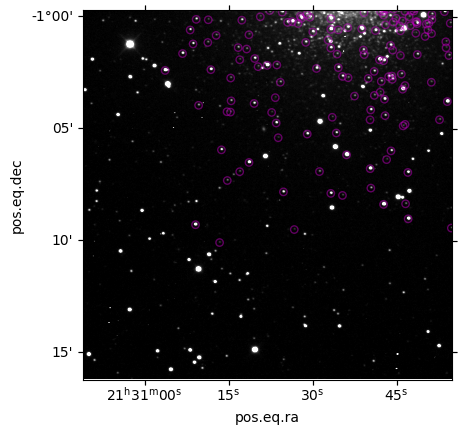

In [ ]:
ax = plt.subplot(projection=wcs)
plt.imshow(analysis.data, vmin=np.median(image1[0].data), vmax=3 * np.median(image1[0].data), cmap="Greys_r")
_ = CircularAperture(stetson_pos, 10).plot(color="m", alpha=0.5)

In [60]:
mean, median, std = sigma_clipped_stats(analysis.data, sigma=3.0)

daofind = DAOStarFinder(fwhm=7.0, threshold=5.*std)
sources = daofind(analysis.data - median)
for col in sources.colnames:  

    if col not in ('id', 'npix'):

        sources[col].info.format = '%.2f'  # for consistent table output
sources.pprint()

 id xcentroid ycentroid sharpness roundness1 ... peak flux  mag  daofind_mag
--- --------- --------- --------- ---------- ... ---- ---- ----- -----------
  1    131.47      1.24      0.63      -0.10 ... 0.00 0.04  3.48       -0.69
  2     93.49     16.30      0.61       0.05 ... 0.01 0.19  1.82       -1.93
  3    853.04     15.44      0.45       0.20 ... 0.00 0.06  3.12       -0.92
  4    982.80     15.73      0.32       0.19 ... 0.00 0.05  3.16       -0.64
  5    554.19     24.79      0.48      -0.24 ... 0.00 0.03  3.89       -0.42
  6    237.06     25.62      0.55      -0.14 ... 0.36 7.46 -2.18       -5.79
  7    322.30     29.50      0.55      -0.09 ... 0.02 0.50  0.74       -2.88
  8    539.27     36.44      0.53       0.38 ... 0.00 0.02  4.52       -0.31
  9    760.20     36.36      0.63      -0.10 ... 0.00 0.07  2.90       -0.99
 10    322.13     39.06      0.86       0.08 ... 0.00 0.04  3.44       -0.59
...       ...       ...       ...        ... ...  ...  ...   ...         ...

In [61]:
detected_table = sources.to_pandas()

In [62]:
print(detected_table.flux.min(), detected_table.flux.max(), detected_table.flux.mean(), detected_table.flux.median())

0.0042454702110718105 268.90446422635415 1.3568336849791827 0.21165966037233291


In [63]:
detected_table = detected_table[(detected_table.flux > 0.79)]

In [64]:
detected_table

,id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,peak,flux,mag,daofind_mag
5,6,237.055691,25.619694,0.545564,-0.137587,-0.114806,81,0.362372,7.460833,-2.181968,-5.789859
11,12,300.878528,44.854725,0.552110,-0.126132,-0.144826,81,0.171992,3.473084,-1.351788,-4.977300
18,19,313.687666,57.758876,0.547185,-0.093309,-0.156276,81,0.419286,8.628215,-2.339802,-5.945675
21,22,15.277057,66.897160,0.559550,-0.152171,-0.165719,81,0.429074,8.599469,-2.336179,-5.959450
22,23,201.061181,75.572453,0.544573,-0.118626,-0.110897,81,0.177639,3.659914,-1.408677,-5.017445
...,...,...,...,...,...,...,...,...,...,...,...
808,809,505.566417,997.359640,0.547872,-0.229116,-0.314089,81,0.109534,2.097593,-0.804303,-4.520037
811,812,705.999004,996.002919,0.391158,-0.781582,-0.643588,81,0.017587,0.820803,0.214403,-2.169331
815,816,650.315868,997.215564,0.572892,-0.211553,-0.677771,81,0.026162,0.834454,0.196494,-2.661596
816,817,717.160582,997.917227,0.554585,-0.148266,-0.620390,81,0.052643,1.158015,-0.159285,-3.662528


In [65]:
det_pos = np.transpose((detected_table['xcentroid'], detected_table['ycentroid']))

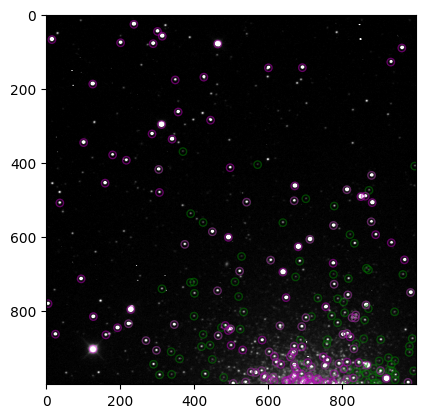

In [66]:
stetson_pos = np.array(wcs_cutout.world_to_pixel_values(stetson[["RA", "DEC"]]))

#apertures = CircularAperture(positions, r=6.0)
#ax = plt.subplot(projection=wcs)
plt.imshow(analysis.data, vmin=np.median(image1[0].data), vmax=3 * np.median(image1[0].data), cmap="Greys_r")
_ = CircularAperture(stetson_pos, 10).plot(color="g", alpha=0.5)
_ = CircularAperture(det_pos, 10).plot(color="m", alpha=0.5)
#apertures.plot(color='red', lw=1.5, alpha=0.5)

In [67]:
stetson[['RA', 'DEC']]

,RA,DEC
1,323.388666,-0.825776
2,323.392878,-0.848818
3,323.390901,-0.836977
4,323.395248,-0.860628
5,323.391814,-0.841135
...,...,...
1401,323.514497,-0.973412
1410,323.534195,-0.979178
1415,323.539763,-0.708714
1426,323.557856,-0.985903


In [68]:
detected_table

,id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,peak,flux,mag,daofind_mag
5,6,237.055691,25.619694,0.545564,-0.137587,-0.114806,81,0.362372,7.460833,-2.181968,-5.789859
11,12,300.878528,44.854725,0.552110,-0.126132,-0.144826,81,0.171992,3.473084,-1.351788,-4.977300
18,19,313.687666,57.758876,0.547185,-0.093309,-0.156276,81,0.419286,8.628215,-2.339802,-5.945675
21,22,15.277057,66.897160,0.559550,-0.152171,-0.165719,81,0.429074,8.599469,-2.336179,-5.959450
22,23,201.061181,75.572453,0.544573,-0.118626,-0.110897,81,0.177639,3.659914,-1.408677,-5.017445
...,...,...,...,...,...,...,...,...,...,...,...
808,809,505.566417,997.359640,0.547872,-0.229116,-0.314089,81,0.109534,2.097593,-0.804303,-4.520037
811,812,705.999004,996.002919,0.391158,-0.781582,-0.643588,81,0.017587,0.820803,0.214403,-2.169331
815,816,650.315868,997.215564,0.572892,-0.211553,-0.677771,81,0.026162,0.834454,0.196494,-2.661596
816,817,717.160582,997.917227,0.554585,-0.148266,-0.620390,81,0.052643,1.158015,-0.159285,-3.662528


In [69]:
detected_table['coords'] = wcs_cutout.pixel_to_world(detected_table['xcentroid'], detected_table['ycentroid'])

In [70]:
detected_table

,id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,peak,flux,mag,daofind_mag,coords
5,6,237.055691,25.619694,0.545564,-0.137587,-0.114806,81,0.362372,7.460833,-2.181968,-5.789859,"<SkyCoord (ICRS): (ra, dec) in deg\n (323.2..."
11,12,300.878528,44.854725,0.552110,-0.126132,-0.144826,81,0.171992,3.473084,-1.351788,-4.977300,"<SkyCoord (ICRS): (ra, dec) in deg\n (323.2..."
18,19,313.687666,57.758876,0.547185,-0.093309,-0.156276,81,0.419286,8.628215,-2.339802,-5.945675,"<SkyCoord (ICRS): (ra, dec) in deg\n (323.2..."
21,22,15.277057,66.897160,0.559550,-0.152171,-0.165719,81,0.429074,8.599469,-2.336179,-5.959450,"<SkyCoord (ICRS): (ra, dec) in deg\n (323.1..."
22,23,201.061181,75.572453,0.544573,-0.118626,-0.110897,81,0.177639,3.659914,-1.408677,-5.017445,"<SkyCoord (ICRS): (ra, dec) in deg\n (323.2..."
...,...,...,...,...,...,...,...,...,...,...,...,...
808,809,505.566417,997.359640,0.547872,-0.229116,-0.314089,81,0.109534,2.097593,-0.804303,-4.520037,"<SkyCoord (ICRS): (ra, dec) in deg\n (323.3..."
811,812,705.999004,996.002919,0.391158,-0.781582,-0.643588,81,0.017587,0.820803,0.214403,-2.169331,"<SkyCoord (ICRS): (ra, dec) in deg\n (323.3..."
815,816,650.315868,997.215564,0.572892,-0.211553,-0.677771,81,0.026162,0.834454,0.196494,-2.661596,"<SkyCoord (ICRS): (ra, dec) in deg\n (323.3..."
816,817,717.160582,997.917227,0.554585,-0.148266,-0.620390,81,0.052643,1.158015,-0.159285,-3.662528,"<SkyCoord (ICRS): (ra, dec) in deg\n (323.3..."


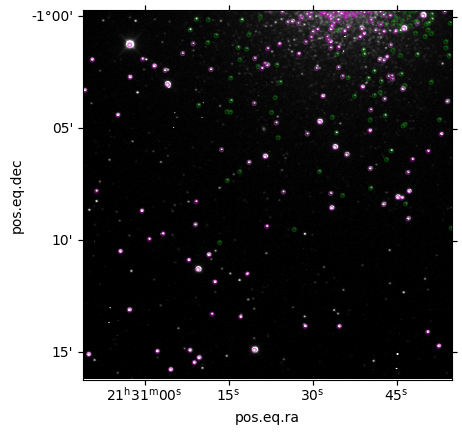

In [71]:
#stetson_pos = np.array(wcs_cutout.world_to_pixel_values(stetson[["RA", "DEC"]]))

#apertures = CircularAperture(positions, r=6.0)
ax = plt.subplot(projection=wcs)
plt.imshow(analysis.data, vmin=np.median(image1[0].data), vmax=3 * np.median(image1[0].data), cmap="Greys_r")
_ = CircularAperture(stetson_pos, 5).plot(color="g", alpha=0.5)
_ = CircularAperture(det_pos, 5).plot(color="m", alpha=0.5)
#apertures.plot(color='red', lw=1.5, alpha=0.5)

In [72]:
#https://docs.astropy.org/en/stable/coordinates/matchsep.html

In [73]:
c_stetson = SkyCoord(stetson.RA, stetson.DEC, unit=u.degree)

In [74]:
det_radec = wcs_cutout.pixel_to_world(detected_table['xcentroid'], detected_table['ycentroid'])
c_det = SkyCoord(det_radec.ra, det_radec.dec)

In [75]:
idx, d2d, d3d = c_det.match_to_catalog_sky(c_stetson)

In [76]:
stetson['sky'] = SkyCoord(stetson.RA, stetson.DEC, unit=u.degree)

C:\Users\king_\AppData\Local\Temp\ipykernel_19276\2317676568.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stetson['sky'] = SkyCoord(stetson.RA, stetson.DEC, unit=u.degree)


In [77]:
max_sep = 1.0 * u.arcsec
sep_constraint = d2d < max_sep
c_matches = c_det[sep_constraint]
catalog_matches = c_stetson[idx[sep_constraint]]

In [78]:
catalog_matches

<SkyCoord (ICRS): (ra, dec) in deg
    [(323.25537374, -1.01691898), (323.4137256 , -1.01229824),
     (323.39537654, -1.00159929), (323.356107  , -0.9934261 ),
     (323.32080924, -0.99237698), (323.41344976, -0.97775908),
     (323.38539346, -0.97501325), (323.29515306, -0.97050078),
     (323.36778952, -0.96473943), (323.27459841, -0.9611398 ),
     (323.33848522, -0.94930575), (323.31536438, -0.94110554),
     (323.3857271 , -0.93127298), (323.2989002 , -0.92658446),
     (323.44280866, -0.92496302), (323.39597255, -0.92327706),
     (323.40948949, -0.9158047 ), (323.40182592, -0.90843145),
     (323.3647146 , -0.90637694), (323.39909501, -0.90643176),
     (323.40149697, -0.9060184 ), (323.23260908, -0.90210751),
     (323.26666109, -0.90146685), (323.34533193, -0.90045635),
     (323.36155865, -0.89980166), (323.30860215, -0.89818962),
     (323.39534527, -0.89458652), (323.39222933, -0.89389737),
     (323.29930776, -0.89313142), (323.24556497, -0.88950738),
     (323.35595271, 

In [79]:
detected_table['coords']=c_det

In [80]:
det_array = []
for i in detected_table.index:
    for j in range(0,len(c_matches)):
        if detected_table.coords[i] == c_matches[j]:
            det_array.append(detected_table.mag[i])
#Here mag: the object instrumental magnitude calculated as -2.5 * log10(flux)

In [81]:
calib_array = []
for i in stetson.index:
    for j in range(0,len(catalog_matches)):
        if(stetson.sky[i] == catalog_matches[j]):
            calib_array.append(stetson.B[i])
#        if stetson.sky[i] == c_matches[j]:
#            mag_array.append(detected_table.flux[i])

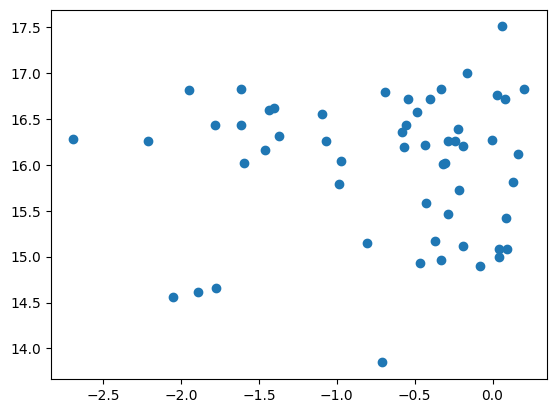

In [82]:
plt.scatter(det_array, calib_array)